# Creación de un ejemplo adversarial

In [1]:

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
##Funciones auxiliares
def plotImage( img, dims = False ):
    if not(dims):
        plt.imshow(img, vmin=0., vmax=1.)
    else: 
        plt.imshow(img.reshape(dims), vmin=0., vmax=1.)
    plt.show()
        

model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plotImage(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x_not_pre = x
x = preprocess_input(x)





Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

Eligamos una imagen para crear ejemplo adversarial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


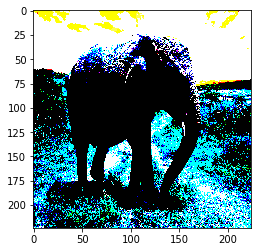

In [2]:
#select image to create an adversarial example from
img = x
plt.imshow(img.reshape((224,224,3)),vmin=0., vmax=1.)
plt.show()

Veamos qué clasificacion da el modelo

In [3]:
preds = model.predict(x)
print(preds.shape)
target = np.zeros((1,1000))
target[0,4] = 1
print('Predicted:', decode_predictions(target, top=3)[0])
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

(1, 1000)
Predicted: [('n01494475', 'hammerhead', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02319095', 'sea_urchin', 0.0)]
Predicted: [('n02504458', 'African_elephant', 0.86625427), ('n02504013', 'Indian_elephant', 0.06860924), ('n01871265', 'tusker', 0.06478469)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


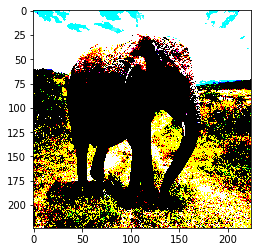

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[  2.3199997  21.221      56.060997 ]
  [-10.68       10.221001   49.060997 ]
  [ -9.68       14.221001   57.060997 ]
  ...
  [ 87.32       95.221     113.061    ]
  [ 94.32      102.221     120.061    ]
  [ 90.32       98.221     116.061    ]]

 [[ -3.6800003  14.221001   49.060997 ]
  [ -6.6800003  12.221001   51.060997 ]
  [ -3.6800003  18.221      62.060997 ]
  ...
  [ 94.32      100.221     119.061    ]
  [ 99.32      106.221     127.061    ]
  [ 86.32       93.221     114.061    ]]

 [[ -9.68        9.221001   46.060997 ]
  [  2.3199997  23.221      62.060997 ]
  [-14.68        7.2210007  49.060997 ]
  ...
  [101.32      107.221     125.061    ]
  [ 86.32       96.221     116.061    ]
  [ 71.32       81.221     101.061    ]]

 ...

 [[-67.68      -77.779     -90.939    ]
  [-15.68      -32.779     -45.939003 ]
  [ -7.6800003 -29.779     -46.939003 ]
  ...
  [ 32.32       19.221      -2.939003 ]
  [ 25.32        8.221001  -16.939003 ]
  [ 36.32       19.221      -5.939003 ]]

 [

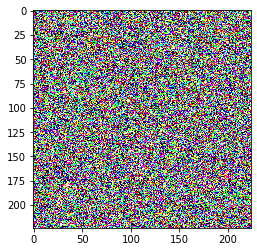

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


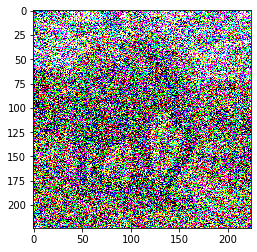

Predicted: [('n03347037', 'fire_screen', 0.75105536), ('n03000134', 'chainlink_fence', 0.24886224), ('n04589890', 'window_screen', 5.6396148e-05)]


In [4]:
#applying random noise does not fool the classifier
#quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.3, size=img.shape) * 255.) / 255.
quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.8, size=x_not_pre.shape) * 255.)
#noisy_img = np.clip(img + quantized_noise, 0., 1.)
#plt.imshow(quantized_noise[0],vmin=0., vmax=1.)
plotImage(x_not_pre[0])
print(x_not_pre[0])
#plt.show()
plotImage(quantized_noise[0])
noisy_img = x_not_pre[0] + quantized_noise[0]
print(noisy_img.shape)
plotImage(noisy_img)
noisy_img_pre = np.expand_dims(noisy_img, axis=0)
noisy_img_pre = preprocess_input(noisy_img_pre)
preds = model.predict(noisy_img_pre)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
#### AQUI HAY ERROR
print('Predicted:', decode_predictions(preds, top=3)[0])

In [8]:

#custom activation function for keeping adversarial pixel values between 0.0 and 1.0
def clip(x):
    return K.clip(x, 0.0, 1.0)

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#custom activation to transform image to resnet input format
def preprocessImg(img):
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return preprocess_input(img)

#add custom objects to dictionary
get_custom_objects().update({'clip': Activation(clip)})
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})
get_custom_objects().update({'preprocess': preprocessImg})


def define_adversarial_model(img_shape, regularization, classifier):
    h = img_shape[0]
    w = img_shape[1]
    numChannels = img_shape[2]
    #input for base image
    image = Input(shape=img_shape,name='image')
    #unit input for adversarial noise
    one = Input(shape=(1,),name='unity')
    
    #layer for learning adversarial noise to apply to image
    noise = Dense(h*w*numChannels,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #reshape noise in shape of image
    noise = Reshape(img_shape, name='reshape')(noise)
    
    #add noise to image
    net = Add(name='add')([noise,image])
    #clip values to be within 0.0 and 1.0
    #net = Activation('clip',name='clip_values')(net)
    
    #add preprocess activation
    #net = Activation('preprocess',name='pre_values')(net)
    
    #conecta imagen con ruido adversarial a classificador
    outputs = classifier(net)
    outputs = Reshape((1000,), name='reshape_resnet')(outputs)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #vuelve estáticos los parametros del classificador, solo entrena capa de ruido
    adversarial_model.layers[-1].trainable = False
    return adversarial_model

def entrena_modelo_adversarial(adversarial_model, target, img, num_epocas):
    #target adversarial classification
    #target adversarial classification
    target_vector = np.zeros(1000)
    target_vector[target] = 1.
    
    #callback for saving weights with smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights_resnet.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                mode='auto', period=1)
    #train adversarial image
    adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=num_epocas,verbose=2,
    callbacks=[checkpoint])
    #adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=num_epocas,verbose=2)
    #restore best weights
    adversarial_model.load_weights('./adversarial_weights_resnet.h5')
    
def recupera_ruido(adversarial_model):
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224,224,3)) * 255.) / 255.
    weights = adversarial_model.get_weights()[0].reshape((224,224,3))
    return weights

def clasifica_resnet(img):
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    prediccion =  model.predict(img)
    return decode_predictions(prediccion, top=3)[0]
def clasifica_mod_adversarial(inp, net):
    pred =  net.predict(inp)
    return decode_predictions(pred, top=3)[0]
#generate_adversary(x_not_pre,5,model,l1(0.01),'negative_categorical_crossentropy')


In [9]:
adversarial_model = define_adversarial_model((224,224,3),l1(0.0000001),model)
adversarial_model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

In [10]:
target = 4
target_vector = np.zeros((1,1000))
target_vector[0, target] = 1
print(decode_predictions(target_vector, top = 3)[0])
entrena_modelo_adversarial(adversarial_model,target,x, 500)

[('n01494475', 'hammerhead', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02319095', 'sea_urchin', 0.0)]
Epoch 1/500
 - 19s - loss: 6.8687 - categorical_accuracy: 0.0000e+00
Epoch 2/500
 - 0s - loss: 0.0845 - categorical_accuracy: 1.0000
Epoch 3/500
 - 0s - loss: 6.1335e-04 - categorical_accuracy: 1.0000
Epoch 4/500
 - 0s - loss: 6.0873e-04 - categorical_accuracy: 1.0000
Epoch 5/500
 - 0s - loss: 6.0599e-04 - categorical_accuracy: 1.0000
Epoch 6/500
 - 0s - loss: 6.0416e-04 - categorical_accuracy: 1.0000
Epoch 7/500
 - 0s - loss: 6.0301e-04 - categorical_accuracy: 1.0000
Epoch 8/500
 - 0s - loss: 6.0212e-04 - categorical_accuracy: 1.0000
Epoch 9/500
 - 0s - loss: 6.0143e-04 - categorical_accuracy: 1.0000
Epoch 10/500
 - 0s - loss: 6.0076e-04 - categorical_accuracy: 1.0000
Epoch 11/500
 - 0s - loss: 6.0011e-04 - categorical_accuracy: 1.0000
Epoch 12/500
 - 0s - loss: 5.9949e-04 - categorical_accuracy: 1.0000
Epoch 13/500
 - 0s - loss: 5.9890e-04 - categorical_accuracy: 1.0000
Epoch 14/

 - 0s - loss: 4.8667e-04 - categorical_accuracy: 1.0000
Epoch 119/500
 - 0s - loss: 4.8552e-04 - categorical_accuracy: 1.0000
Epoch 120/500
 - 0s - loss: 4.8439e-04 - categorical_accuracy: 1.0000
Epoch 121/500
 - 0s - loss: 4.8325e-04 - categorical_accuracy: 1.0000
Epoch 122/500
 - 0s - loss: 4.8212e-04 - categorical_accuracy: 1.0000
Epoch 123/500
 - 1s - loss: 4.8098e-04 - categorical_accuracy: 1.0000
Epoch 124/500
 - 0s - loss: 4.7985e-04 - categorical_accuracy: 1.0000
Epoch 125/500
 - 0s - loss: 4.7872e-04 - categorical_accuracy: 1.0000
Epoch 126/500
 - 0s - loss: 4.7760e-04 - categorical_accuracy: 1.0000
Epoch 127/500
 - 0s - loss: 4.7646e-04 - categorical_accuracy: 1.0000
Epoch 128/500
 - 0s - loss: 4.7535e-04 - categorical_accuracy: 1.0000
Epoch 129/500
 - 0s - loss: 4.7422e-04 - categorical_accuracy: 1.0000
Epoch 130/500
 - 0s - loss: 4.7311e-04 - categorical_accuracy: 1.0000
Epoch 131/500
 - 0s - loss: 4.7198e-04 - categorical_accuracy: 1.0000
Epoch 132/500
 - 0s - loss: 4.7087

Epoch 236/500
 - 0s - loss: 3.6575e-04 - categorical_accuracy: 1.0000
Epoch 237/500
 - 0s - loss: 3.6484e-04 - categorical_accuracy: 1.0000
Epoch 238/500
 - 0s - loss: 3.6395e-04 - categorical_accuracy: 1.0000
Epoch 239/500
 - 0s - loss: 3.6304e-04 - categorical_accuracy: 1.0000
Epoch 240/500
 - 0s - loss: 3.6215e-04 - categorical_accuracy: 1.0000
Epoch 241/500
 - 0s - loss: 3.6125e-04 - categorical_accuracy: 1.0000
Epoch 242/500
 - 0s - loss: 3.6036e-04 - categorical_accuracy: 1.0000
Epoch 243/500
 - 0s - loss: 3.5947e-04 - categorical_accuracy: 1.0000
Epoch 244/500
 - 0s - loss: 3.5859e-04 - categorical_accuracy: 1.0000
Epoch 245/500
 - 0s - loss: 3.5769e-04 - categorical_accuracy: 1.0000
Epoch 246/500
 - 0s - loss: 3.5682e-04 - categorical_accuracy: 1.0000
Epoch 247/500
 - 0s - loss: 3.5593e-04 - categorical_accuracy: 1.0000
Epoch 248/500
 - 0s - loss: 3.5506e-04 - categorical_accuracy: 1.0000
Epoch 249/500
 - 0s - loss: 3.5417e-04 - categorical_accuracy: 1.0000
Epoch 250/500
 - 0s 

 - 0s - loss: 2.7308e-04 - categorical_accuracy: 1.0000
Epoch 354/500
 - 0s - loss: 2.7240e-04 - categorical_accuracy: 1.0000
Epoch 355/500
 - 0s - loss: 2.7170e-04 - categorical_accuracy: 1.0000
Epoch 356/500
 - 0s - loss: 2.7103e-04 - categorical_accuracy: 1.0000
Epoch 357/500
 - 0s - loss: 2.7033e-04 - categorical_accuracy: 1.0000
Epoch 358/500
 - 0s - loss: 2.6966e-04 - categorical_accuracy: 1.0000
Epoch 359/500
 - 0s - loss: 2.6897e-04 - categorical_accuracy: 1.0000
Epoch 360/500
 - 0s - loss: 2.6830e-04 - categorical_accuracy: 1.0000
Epoch 361/500
 - 0s - loss: 2.6762e-04 - categorical_accuracy: 1.0000
Epoch 362/500
 - 0s - loss: 2.6695e-04 - categorical_accuracy: 1.0000
Epoch 363/500
 - 0s - loss: 2.6627e-04 - categorical_accuracy: 1.0000
Epoch 364/500
 - 0s - loss: 2.6560e-04 - categorical_accuracy: 1.0000
Epoch 365/500
 - 0s - loss: 2.6492e-04 - categorical_accuracy: 1.0000
Epoch 366/500
 - 0s - loss: 2.6427e-04 - categorical_accuracy: 1.0000
Epoch 367/500
 - 0s - loss: 2.6359

Epoch 471/500
 - 0s - loss: 2.0259e-04 - categorical_accuracy: 1.0000
Epoch 472/500
 - 0s - loss: 2.0208e-04 - categorical_accuracy: 1.0000
Epoch 473/500
 - 0s - loss: 2.0156e-04 - categorical_accuracy: 1.0000
Epoch 474/500
 - 0s - loss: 2.0106e-04 - categorical_accuracy: 1.0000
Epoch 475/500
 - 0s - loss: 2.0054e-04 - categorical_accuracy: 1.0000
Epoch 476/500
 - 0s - loss: 2.0004e-04 - categorical_accuracy: 1.0000
Epoch 477/500
 - 0s - loss: 1.9952e-04 - categorical_accuracy: 1.0000
Epoch 478/500
 - 1s - loss: 1.9903e-04 - categorical_accuracy: 1.0000
Epoch 479/500
 - 0s - loss: 1.9851e-04 - categorical_accuracy: 1.0000
Epoch 480/500
 - 0s - loss: 1.9802e-04 - categorical_accuracy: 1.0000
Epoch 481/500
 - 0s - loss: 1.9750e-04 - categorical_accuracy: 1.0000
Epoch 482/500
 - 0s - loss: 1.9701e-04 - categorical_accuracy: 1.0000
Epoch 483/500
 - 0s - loss: 1.9650e-04 - categorical_accuracy: 1.0000
Epoch 484/500
 - 0s - loss: 1.9601e-04 - categorical_accuracy: 1.0000
Epoch 485/500
 - 0s 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


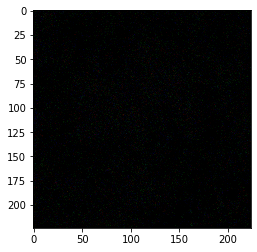

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen
[[[[ 56.060997   21.221       2.3199997]
   [ 49.060997   10.221001  -10.68     ]
   [ 57.060997   14.221001   -9.68     ]
   ...
   [113.061      95.221      87.32     ]
   [120.061     102.221      94.32     ]
   [116.061      98.221      90.32     ]]

  [[ 49.060997   14.221001   -3.6800003]
   [ 51.060997   12.221001   -6.6800003]
   [ 62.060997   18.221      -3.6800003]
   ...
   [119.061     100.221      94.32     ]
   [127.061     106.221      99.32     ]
   [114.061      93.221      86.32     ]]

  [[ 46.060997    9.221001   -9.68     ]
   [ 62.060997   23.221       2.3199997]
   [ 49.060997    7.2210007 -14.68     ]
   ...
   [125.061     107.221     101.32     ]
   [116.061      96.221      86.32     ]
   [101.061      81.221      71.32     ]]

  ...

  [[-90.939     -77.779     -67.68     ]
   [-45.939003  -32.779     -15.68     ]
   [-46.939003  -29.779      -7.6800003]
   ...
   [ -2.939003   19.221      32.32     ]
   [-16.939003    8.221001   25.32     ]
   [ -5.9

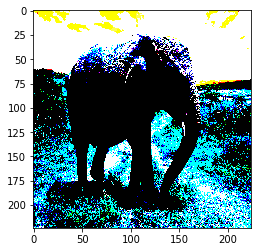

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


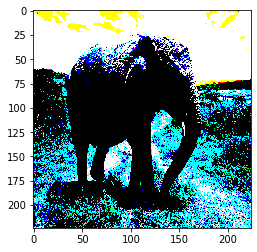

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


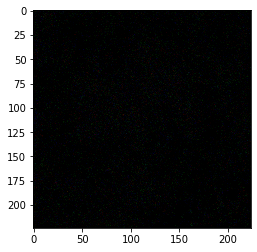

[('n01494475', 'hammerhead', 1.0), ('n02092339', 'Weimaraner', 1.0459673e-09), ('n02091032', 'Italian_greyhound', 1.0042234e-09)]
[('n01494475', 'hammerhead', 1.0), ('n02092339', 'Weimaraner', 1.0459673e-09), ('n02091032', 'Italian_greyhound', 1.0042234e-09)]


In [11]:
#adversarial_model.load_weights('./adversarial_weights_resnet.h5')
ruido = adversarial_model.get_weights()[0].reshape((224,224,3))
#ruido = 55* ruido
#img_pre = preprocessImg(ruido + x_not_pre)
plotImage(ruido)
print('Imagen')
print(x)
print('Ruido')
print(ruido)
imagen_adversarial = x + ruido
print(imagen_adversarial.shape)
plotImage(x[0])
plotImage(imagen_adversarial[0])
plotImage(imagen_adversarial[0] - x[0])
print(decode_predictions(model.predict(imagen_adversarial), top=3)[0])
print(clasifica_mod_adversarial({'image':x,'unity':np.ones(shape=(1,1))}, adversarial_model))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
unity (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
adversarial_noise (Dense)       (None, 150528)       150528      unity[0][0]                      
__________________________________________________________________________________________________
reshape (Reshape)               (None, 224, 224, 3)  0           adversarial_noise[0][0]          
__________________________________________________________________________________________________
image (InputLayer)              (None, 224, 224, 3)  0                                            
____________________________________________________________________________________________

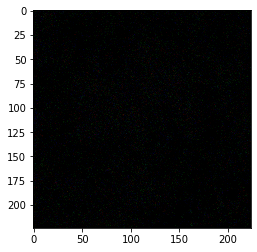

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('n01494475', 'hammerhead', 1.0), ('n02092339', 'Weimaraner', 1.0459673e-09), ('n02091032', 'Italian_greyhound', 1.0042234e-09)]


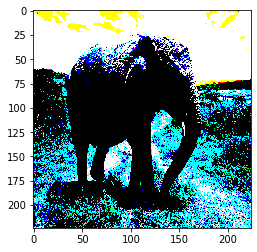

In [24]:
adversarial_model.summary()
#np.save('imagen_adversarial_resnet', imagen_adversarial)
c = np.load('imagen_adversarial_resnet.npy')
#np.save('ruido_adversarial',ruido)
r = np.load('ruido_adversarial.npy')
plotImage(r)
print(decode_predictions(model.predict(c), top=3)[0])
plotImage(c[0])


In [ ]:
target_vector = np.zeros((1,1000))
target_vector[0,4] = 1
pred = model.predict(x)
print(np.argmax(pred))
print(np.argmax(target_vector))
print(adversarial_model.evaluate({'image':x,'unity':np.ones(shape=(1,1))}, target_vector))